In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import tensorflow as tf 

%matplotlib inline

In [2]:
import utils as ut
early_stopping = ut.EarlyStopping(patience=100, verbose=1)

# 1. Create Data for Toy Problem

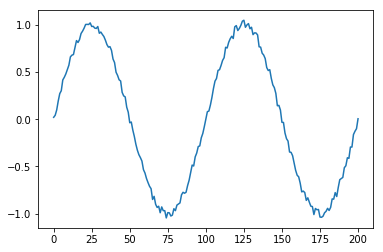

In [3]:
seed_int=123

rng = np.random.RandomState(seed_int)

def sin(x, T=100):
    return np.sin(2.0 * np.pi * x/T)

def toy_problem(T=100, ampl=0.05):
    x = np.arange(0, 2*T + 1)
    noise = ampl*rng.uniform(low = -1.0, high = 1.0, size=len(x))
    return sin(x) + noise

T = 100
f = toy_problem(T)
plt.plot(f)

# 2a. Prepare Input Data to Train the Model

In [4]:
length_of_sequences = 2*T
maxlen = 25
data = []
target = []

for i in range(0, length_of_sequences - maxlen + 1):
    data.append(f[i: i + maxlen])
    target.append(f[i + maxlen])

X = np.array(data).reshape(len(data), maxlen, 1)
Y = np.array(target).reshape(len(data), 1)

# 2b. Split Data into Training and Valdiation Set 

In [5]:
N_train = int(len(data) * 0.9)
N_validation = len(data) - N_train
X_train, X_validation, Y_train, Y_validation = \
train_test_split(X, Y, test_size=N_validation, random_state=seed_int)

# 3. Prepare Model Functions for Graph

In [6]:
def aweight_variable(shape, name=None):
    initial = tf.truncated_normal(shape, stddev=0.01) # resample 2 sd vals
    return tf.Variable(initial, name=name)
    
def abias_variable(shape, name=None):
    initial = tf.zeros(shape, dtype=tf.float32)
    return tf.Variable(initial, name=name)

def weight_variable(shape, name=None):
    initial = tf.truncated_normal(shape, stddev=0.01) # resample 2 sd vals
    return tf.get_variable(name, dtype=tf.float32, initializer=initial)
    
def bias_variable(shape, name=None):
    initial = tf.zeros(shape, dtype=tf.float32)
    return tf.get_variable(name, dtype=tf.float32, initializer=initial)

In [9]:

def infere_mn(x, n_batch, maxlen=None, n_hidden=None, n_out=None, 
                n_in=None):
    V = weight_variable([n_hidden, n_out], 'V')
    c = bias_variable([n_out], 'c')

    with tf.variable_scope('RNN'):
        # going to combine this as (x, U)
        U = weight_variable([n_in, n_hidden], 'U') 
        W = weight_variable([n_hidden, n_hidden], 'W')
        b = bias_variable([n_hidden], 'b')
        hlist = []
        h_prev = tf.zeros([n_batch, n_hidden], dtype=tf.float32)
        for i in range(maxlen):
            if i > 0:
                tf.get_variable_scope().reuse_variables()
                h_prev = hlist[-1]
            h_i = tf.tanh(tf.matmul(x[:, i, :], U) + tf.matmul(h_prev, W) + b)
            hlist.append(h_i)
    h_last = hlist[-1]
    y = tf.matmul(h_last, V) + c
    return y, [V, U, W, b, c]

def loss(y, t):
    mse = tf.reduce_mean(tf.square(y - t))
    return mse

def training(loss):
    optimize = tf.train.AdamOptimizer(learning_rate = 0.001, beta1=0.9, beta2=0.999)
    train_step = optimize.minimize(loss)
    return train_step

def inference_RNN(x, n_batch, maxlen=None, n_hidden=None, n_out=None, n_in=None):
    def weight_variable(shape):
        initial = tf.truncated_normal(shape, stddev=0.01) # resample 2 sd vals
        return tf.Variable(initial)
    
    def bias_variable(shape):
        initial = tf.zeros(shape, dtype=tf.float32)
        return tf.Variable(initial)
    
    cell = tf.contrib.rnn.BasicRNNCell(n_hidden)
    initial_state = cell.zero_state(n_batch, tf.float32)
    
    state = initial_state
    outputs = []
    with tf.variable_scope('RNN'):
        for t in range(maxlen):
            if t > 0:
                tf.get_variable_scope().reuse_variables()
            (cell_output, state) = cell(x[:, t, :], state)
            outputs.append(cell_output)
    output = outputs[-1]
    
    V = weight_variable([n_hidden, n_out])
    c = bias_variable([n_out])
    y = tf.matmul(output, V) + c
    
    return y, cell.variables


# 4. Define Graph

In [10]:
tf.reset_default_graph()

maxlen = 25
n_hidden = 20
n_out = 1
n_in = 1

x = tf.placeholder(tf.float32, shape=[None, maxlen, n_in])
t = tf.placeholder(tf.float32, shape=[None, n_out])
n_batch = tf.placeholder(tf.int32, [])

# TF Variables
#y = infere_mn(x, n_batch, maxlen=maxlen, n_hidden=n_hidden, n_out= n_out, n_in=n_in)
y, cvars = infere_mn(x, n_batch, maxlen=maxlen, n_hidden=n_hidden, n_out= n_out, n_in=n_in)
loss = loss(y, t)
train_step = training(loss)


# 5. Run Computational Graph

In [12]:
epochs = 1000
batch_size = 10

tf.set_random_seed(seed_int)
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
history= {'val_loss': []}
n_batches = N_train // batch_size
early_stopping = ut.EarlyStopping(patience=100, verbose=1)
for epoch in range(epochs):
    X_, Y_ = shuffle(X_train, Y_train, random_state = seed_int)
    
    for i in range(n_batches):
        start = i*batch_size
        end = start + batch_size
        
        sess.run(train_step, feed_dict={
            x: X_[start:end],
            t: Y_[start:end],
            n_batch: batch_size
        })
    val_loss = loss.eval(session=sess, feed_dict={
        x: X_validation,
        t: Y_validation,
        n_batch: N_validation
    })
    history['val_loss'].append(val_loss)
    print('epoch:', epoch, ' validation loss: ', val_loss)
    #Early Stopping
    if early_stopping.validate(val_loss):
        break

epoch: 0  validation loss:  0.562893
epoch: 1  validation loss:  0.506196
epoch: 2  validation loss:  0.244817
epoch: 3  validation loss:  0.133555
epoch: 4  validation loss:  0.077604
epoch: 5  validation loss:  0.0524217
epoch: 6  validation loss:  0.0385472
epoch: 7  validation loss:  0.0310914
epoch: 8  validation loss:  0.0257704
epoch: 9  validation loss:  0.0223091
epoch: 10  validation loss:  0.0195967
epoch: 11  validation loss:  0.0175748
epoch: 12  validation loss:  0.0159315
epoch: 13  validation loss:  0.0146071
epoch: 14  validation loss:  0.0134986
epoch: 15  validation loss:  0.0125644
epoch: 16  validation loss:  0.0117625
epoch: 17  validation loss:  0.0110675
epoch: 18  validation loss:  0.0104587
epoch: 19  validation loss:  0.0099207
epoch: 20  validation loss:  0.00944158
epoch: 21  validation loss:  0.00901196
epoch: 22  validation loss:  0.00862435
epoch: 23  validation loss:  0.00827271
epoch: 24  validation loss:  0.0079521
epoch: 25  validation loss:  0.00765

epoch: 204  validation loss:  0.00165699
epoch: 205  validation loss:  0.00165437
epoch: 206  validation loss:  0.00165175
epoch: 207  validation loss:  0.00164913
epoch: 208  validation loss:  0.00164651
epoch: 209  validation loss:  0.00164389
epoch: 210  validation loss:  0.00164127
epoch: 211  validation loss:  0.00163865
epoch: 212  validation loss:  0.00163603
epoch: 213  validation loss:  0.00163341
epoch: 214  validation loss:  0.00163079
epoch: 215  validation loss:  0.00162818
epoch: 216  validation loss:  0.00162556
epoch: 217  validation loss:  0.00162295
epoch: 218  validation loss:  0.00162033
epoch: 219  validation loss:  0.00161772
epoch: 220  validation loss:  0.00161511
epoch: 221  validation loss:  0.00161251
epoch: 222  validation loss:  0.0016099
epoch: 223  validation loss:  0.0016073
epoch: 224  validation loss:  0.0016047
epoch: 225  validation loss:  0.0016021
epoch: 226  validation loss:  0.0015995
epoch: 227  validation loss:  0.00159691
epoch: 228  validatio

epoch: 409  validation loss:  0.0010785
epoch: 410  validation loss:  0.00107684
epoch: 411  validation loss:  0.00107521
epoch: 412  validation loss:  0.0010736
epoch: 413  validation loss:  0.001072
epoch: 414  validation loss:  0.00107043
epoch: 415  validation loss:  0.00106888
epoch: 416  validation loss:  0.00106735
epoch: 417  validation loss:  0.00106583
epoch: 418  validation loss:  0.00106433
epoch: 419  validation loss:  0.00106285
epoch: 420  validation loss:  0.00106138
epoch: 421  validation loss:  0.00105993
epoch: 422  validation loss:  0.00105849
epoch: 423  validation loss:  0.00105707
epoch: 424  validation loss:  0.00105566
epoch: 425  validation loss:  0.00105427
epoch: 426  validation loss:  0.00105289
epoch: 427  validation loss:  0.00105153
epoch: 428  validation loss:  0.00105017
epoch: 429  validation loss:  0.00104884
epoch: 430  validation loss:  0.00104751
epoch: 431  validation loss:  0.0010462
epoch: 432  validation loss:  0.0010449
epoch: 433  validation

epoch: 610  validation loss:  0.000907865
epoch: 611  validation loss:  0.000907389
epoch: 612  validation loss:  0.000906918
epoch: 613  validation loss:  0.000906455
epoch: 614  validation loss:  0.000906
epoch: 615  validation loss:  0.000905552
epoch: 616  validation loss:  0.000905111
epoch: 617  validation loss:  0.00090468
epoch: 618  validation loss:  0.000904255
epoch: 619  validation loss:  0.000903839
epoch: 620  validation loss:  0.000903428
epoch: 621  validation loss:  0.000903024
epoch: 622  validation loss:  0.00090263
epoch: 623  validation loss:  0.000902241
epoch: 624  validation loss:  0.000901862
epoch: 625  validation loss:  0.000901488
epoch: 626  validation loss:  0.000901122
epoch: 627  validation loss:  0.000900763
epoch: 628  validation loss:  0.000900411
epoch: 629  validation loss:  0.000900067
epoch: 630  validation loss:  0.000899729
epoch: 631  validation loss:  0.000899398
epoch: 632  validation loss:  0.000899076
epoch: 633  validation loss:  0.0008987

epoch: 806  validation loss:  0.0008841
epoch: 807  validation loss:  0.00088408
epoch: 808  validation loss:  0.000884063
epoch: 809  validation loss:  0.000884042
epoch: 810  validation loss:  0.000884022
epoch: 811  validation loss:  0.000884004
epoch: 812  validation loss:  0.000883984
epoch: 813  validation loss:  0.000883966
epoch: 814  validation loss:  0.000883947
epoch: 815  validation loss:  0.00088393
epoch: 816  validation loss:  0.000883912
epoch: 817  validation loss:  0.000883895
epoch: 818  validation loss:  0.000883877
epoch: 819  validation loss:  0.000883861
epoch: 820  validation loss:  0.000883843
epoch: 821  validation loss:  0.000883826
epoch: 822  validation loss:  0.000883808
epoch: 823  validation loss:  0.000883793
epoch: 824  validation loss:  0.000883775
epoch: 825  validation loss:  0.000883759
epoch: 826  validation loss:  0.000883744
epoch: 827  validation loss:  0.000883728
epoch: 828  validation loss:  0.000883712
epoch: 829  validation loss:  0.000883

# 6. Show Results

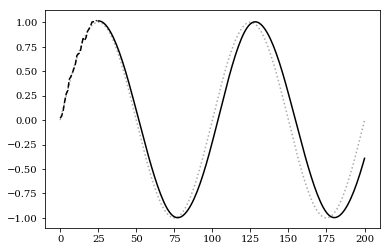

In [13]:
truncate = maxlen
Z = X[:1]
original = [f[i] for i in range(maxlen)]
predicted = [None for i in range(maxlen)]

for i in range(length_of_sequences -maxlen +1):
    z_ = Z[-1:]
    y_ = y.eval(session=sess, feed_dict ={x: Z[-1:],
                                          n_batch: 1})
    sequence_ = np.concatenate((z_.reshape(maxlen, n_in)[1:], y_), axis=0)\
                               .reshape(1, maxlen, n_in)
    Z = np.append(Z, sequence_, axis=0)
    predicted.append(y_.reshape(-1))

plt.rc('font', family='serif')
plt.figure()
plt.plot(toy_problem(T, ampl=0), linestyle='dotted', color='#aaaaaa')
plt.plot(original, linestyle='dashed', color='black')
plt.plot(predicted, color='black')
plt.show()

# 7. Inspect Variables

#### What happened to the variables in RNN cell?

In [14]:
    W = cvars[0].eval(session=sess)
    bias = cvars[1].eval(session=sess)
    print(W.shape) # Note that the first part is from the input x, the second part
                   # From the hidden state
    print(bias.shape)

(20, 1)
(1, 20)


In [15]:
tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='RNN')

[<tf.Variable 'RNN/U:0' shape=(1, 20) dtype=float32_ref>,
 <tf.Variable 'RNN/W:0' shape=(20, 20) dtype=float32_ref>,
 <tf.Variable 'RNN/b:0' shape=(20,) dtype=float32_ref>,
 <tf.Variable 'RNN/U/Adam:0' shape=(1, 20) dtype=float32_ref>,
 <tf.Variable 'RNN/U/Adam_1:0' shape=(1, 20) dtype=float32_ref>,
 <tf.Variable 'RNN/W/Adam:0' shape=(20, 20) dtype=float32_ref>,
 <tf.Variable 'RNN/W/Adam_1:0' shape=(20, 20) dtype=float32_ref>,
 <tf.Variable 'RNN/b/Adam:0' shape=(20,) dtype=float32_ref>,
 <tf.Variable 'RNN/b/Adam_1:0' shape=(20,) dtype=float32_ref>]

In [16]:
tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)

[<tf.Variable 'V:0' shape=(20, 1) dtype=float32_ref>,
 <tf.Variable 'c:0' shape=(1,) dtype=float32_ref>,
 <tf.Variable 'RNN/U:0' shape=(1, 20) dtype=float32_ref>,
 <tf.Variable 'RNN/W:0' shape=(20, 20) dtype=float32_ref>,
 <tf.Variable 'RNN/b:0' shape=(20,) dtype=float32_ref>,
 <tf.Variable 'beta1_power:0' shape=() dtype=float32_ref>,
 <tf.Variable 'beta2_power:0' shape=() dtype=float32_ref>,
 <tf.Variable 'V/Adam:0' shape=(20, 1) dtype=float32_ref>,
 <tf.Variable 'V/Adam_1:0' shape=(20, 1) dtype=float32_ref>,
 <tf.Variable 'c/Adam:0' shape=(1,) dtype=float32_ref>,
 <tf.Variable 'c/Adam_1:0' shape=(1,) dtype=float32_ref>,
 <tf.Variable 'RNN/U/Adam:0' shape=(1, 20) dtype=float32_ref>,
 <tf.Variable 'RNN/U/Adam_1:0' shape=(1, 20) dtype=float32_ref>,
 <tf.Variable 'RNN/W/Adam:0' shape=(20, 20) dtype=float32_ref>,
 <tf.Variable 'RNN/W/Adam_1:0' shape=(20, 20) dtype=float32_ref>,
 <tf.Variable 'RNN/b/Adam:0' shape=(20,) dtype=float32_ref>,
 <tf.Variable 'RNN/b/Adam_1:0' shape=(20,) dtype=fl